In [5]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
from skimage import color, io
from tqdm import tqdm 

In [2]:
df = pd.read_csv('D:/FUCK!!/Pattern/Project/notebooks/image_dataset.csv')

In [8]:
output_gray_dir = 'preprocessed_Gray_images'
output_rgb_dir = 'preprocessed_RGB_images'
os.makedirs(output_gray_dir, exist_ok=True)
os.makedirs(output_rgb_dir, exist_ok=True)

In [1]:
IMG_SIZE = (224, 224) 
BATCH_SIZE = 100
AUGMENTATION_FACTOR = 20

In [2]:
def extract_features(image_path):
    image = io.imread(image_path)

    # 1. LBP
    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype('float')
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    # 2. HOG
    hog_features = hog(image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)

    # 3. Gabor
    gabor_feats = []
    for theta in (0, np.pi/4, np.pi/2, 3*np.pi/4):
        filt_real, filt_imag = gabor(image, frequency=0.6, theta=theta)
        gabor_feats.append(filt_real.mean())
        gabor_feats.append(filt_real.var())
    gabor_feats = np.array(gabor_feats)

    # 4. Color histogram (on original image)
    color_hist = []
    for i in range(3):  # R, G, B
        hist, _ = np.histogram(image[..., i], bins=32, range=(0, 256))
        hist = hist.astype('float')
        hist /= (hist.sum() + 1e-6)
        color_hist.extend(hist)
    color_hist = np.array(color_hist)

    # Concatenate all features
    feature_vector = np.concatenate([lbp_hist, hog_features, gabor_feats, color_hist])
    return feature_vector

In [ ]:
# Split the data into train and validation sets
# First split: 70% train, 30% (val + test)
train_df, temp_df = train_test_split(df,test_size=0.30,stratify=df['label'],random_state=42)

# Second split: 15% val, 15% test from the 30% (split 50-50)
val_df, test_df = train_test_split(temp_df,test_size=0.50,stratify=temp_df['label'],random_state=42)

In [9]:
# Create directories for train and validation
train_gray_dir = os.path.join(output_gray_dir, 'train')
val_gray_dir = os.path.join(output_gray_dir, 'val')
test_gray_dir = os.path.join(output_gray_dir, 'test')
train_rgb_dir = os.path.join(output_rgb_dir, 'train')
val_rgb_dir = os.path.join(output_rgb_dir, 'val')
test_rgb_dir = os.path.join(output_rgb_dir, 'test')


In [8]:
os.makedirs(train_gray_dir, exist_ok=True)  
os.makedirs(val_gray_dir, exist_ok=True)
os.makedirs(test_gray_dir, exist_ok=True)
os.makedirs(train_rgb_dir, exist_ok=True)  
os.makedirs(val_rgb_dir, exist_ok=True)
os.makedirs(test_rgb_dir, exist_ok=True)

# Create subdirectories for each class
for label in df['label'].unique():
    os.makedirs(os.path.join(train_gray_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_gray_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_gray_dir, label), exist_ok=True)
    os.makedirs(os.path.join(train_rgb_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_rgb_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_rgb_dir, label), exist_ok=True)

In [9]:
# Set up data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Process each class separately to ensure all images are augmented
for class_name in df['label'].unique():
    print(f"\nProcessing class: {class_name}")
    
    # Filter dataframes for current class
    class_train_df = train_df[train_df['label'] == class_name]
    class_val_df = val_df[val_df['label'] == class_name]
    class_test_df = test_df[test_df['label'] == class_name]

    
    # Create class-specific directories
    class_train_gray_dir = os.path.join(train_gray_dir, class_name)
    class_val_gray_dir = os.path.join(val_gray_dir, class_name)
    class_test_gray_dir = os.path.join(test_gray_dir, class_name)
    class_train_rgb_dir = os.path.join(train_rgb_dir, class_name)
    class_val_rgb_dir = os.path.join(val_rgb_dir, class_name)
    class_test_rgb_dir = os.path.join(test_rgb_dir, class_name)
    
    # Process training images with augmentation
    print(f"Processing {len(class_train_df)} training images for {class_name}")
    for idx, row in class_train_df.iterrows():
        img_path = row['image_path']
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        
        # Create data generator for this specific image
        single_img_df = pd.DataFrame([row])
        train_generator = train_datagen.flow_from_dataframe(
            dataframe=single_img_df,
            x_col='image_path',
            y_col='label',
            target_size=IMG_SIZE,
            batch_size=1,
            class_mode='categorical',
            color_mode='grayscale',
            save_to_dir=class_train_gray_dir,
            save_format='jpg',
            save_prefix=f'aug_{base_name}_'
        )
        
        # Generate AUGMENTATION_FACTOR augmented versions
        for aug_idx in range(AUGMENTATION_FACTOR):
            next(train_generator)
    
    # Process validation images (no augmentation)
    print(f"Processing {len(class_val_df)} validation images for {class_name}")
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=class_val_df,
        x_col='image_path',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        save_to_dir=class_val_gray_dir,
        save_format='jpg'
    )
    
    # Process all validation images
    for _ in range(len(class_val_df) // BATCH_SIZE + 1):
        next(val_generator)

    print(f"Processing {len(class_test_df)} Testing images for {class_name}")
    test_generator = val_datagen.flow_from_dataframe(
        dataframe=class_test_df,
        x_col='image_path',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        save_to_dir=class_test_gray_dir,
        save_format='jpg'
    )
    
    # Process all validation images
    for _ in range(len(class_test_df) // BATCH_SIZE + 1):
        next(test_generator)


    # Process training images with augmentation
    print(f"Processing {len(class_train_df)} training images for {class_name}")
    for idx, row in class_train_df.iterrows():
        img_path = row['image_path']
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        
        # Create data generator for this specific image
        single_img_df = pd.DataFrame([row])
        train_generator = train_datagen.flow_from_dataframe(
            dataframe=single_img_df,
            x_col='image_path',
            y_col='label',
            target_size=IMG_SIZE,
            batch_size=1,
            class_mode='categorical',
            color_mode='rgb',
            save_to_dir=class_train_rgb_dir,
            save_format='jpg',
            save_prefix=f'aug_{base_name}_'
        )
        
        # Generate AUGMENTATION_FACTOR augmented versions
        for aug_idx in range(AUGMENTATION_FACTOR):
            next(train_generator)
    
    # Process validation images (no augmentation)
    print(f"Processing {len(class_val_df)} validation images for {class_name}")
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=class_val_df,
        x_col='image_path',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        save_to_dir=class_val_rgb_dir,
        save_format='jpg'
    )
    
    # Process all validation images
    for _ in range(len(class_val_df) // BATCH_SIZE + 1):
        next(val_generator)

    print(f"Processing {len(class_test_df)} Testing images for {class_name}")
    test_generator = val_datagen.flow_from_dataframe(
        dataframe=class_test_df,
        x_col='image_path',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        save_to_dir=class_test_rgb_dir,
        save_format='jpg'
    )
    
    # Process all validation images
    for _ in range(len(class_test_df) // BATCH_SIZE + 1):
        next(test_generator)



Processing class: Achaemenid architecture
Processing 226 training images for Achaemenid architecture
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image file

In [7]:
def extract_features_from_dir(data_dir, feature_func):
    features = []
    labels = []
    image_paths = []

    # Gather all image paths and labels first
    all_image_label_paths = []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(class_dir, fname)
                all_image_label_paths.append((img_path, class_name))

    # Single tqdm for all images
    for img_path, class_name in tqdm(all_image_label_paths, desc=f"Processing images in {data_dir}"):
        try:
            feats = feature_func(img_path)
            features.append(feats)
            labels.append(class_name)
            image_paths.append(img_path)
        except Exception as e:
            # Only print errors, not every image
            print(f"Error processing {img_path}: {e}")
    return np.array(features), np.array(labels), image_paths

In [10]:
# For grayscale images
X_train_gray, y_train_gray, train_gray_paths = extract_features_from_dir(train_gray_dir, extract_features)
X_val_gray, y_val_gray, val_gray_paths = extract_features_from_dir(val_gray_dir, extract_features)
X_test_gray, y_test_gray, test_gray_paths = extract_features_from_dir(test_gray_dir, extract_features)

Processing images in preprocessed_Gray_images\train: 100%|██████████| 30580/30580 [22:11<00:00, 22.97it/s]
Processing images in preprocessed_Gray_images\val: 100%|██████████| 328/328 [00:14<00:00, 22.86it/s]
Processing images in preprocessed_Gray_images\test: 100%|██████████| 328/328 [00:14<00:00, 23.37it/s]


In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled = scaler.fit_transform(X_train_gray)
X_val_scaled   = scaler.transform(X_val_gray)
X_test_scaled  = scaler.transform(X_test_gray)

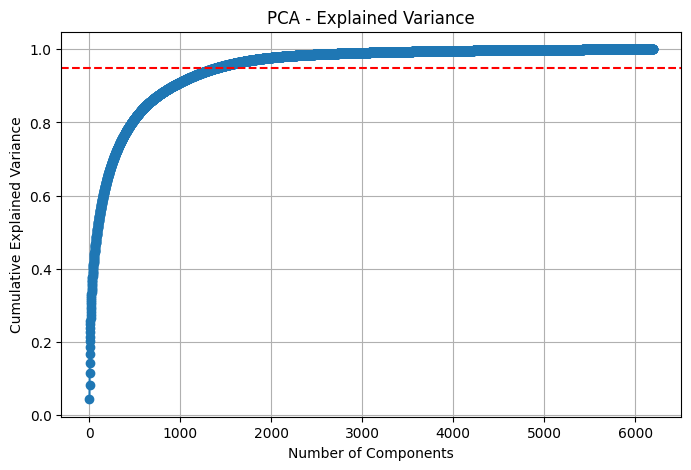

In [12]:
# Fit PCA without reducing dimensions yet
pca = PCA()
pca.fit(X_train_scaled)

# Plot cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--')  # 95% line
plt.title('PCA - Explained Variance')
plt.show()

In [13]:
pca = PCA(n_components=0.95) 
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)
X_test_pca  = pca.transform(X_test_scaled)

In [15]:
os.makedirs("Feature Extracted", exist_ok=True)  

np.save('D:/FUCK!!/Pattern/Project/notebooks/Feature Extracted/X_train_gray.npy', X_train_pca)
np.save('D:/FUCK!!/Pattern/Project/notebooks/Feature Extracted/y_train_gray.npy', y_train_gray)
np.save('D:/FUCK!!/Pattern/Project/notebooks/Feature Extracted/X_val_gray.npy', X_val_pca)
np.save('D:/FUCK!!/Pattern/Project/notebooks/Feature Extracted/y_val_gray.npy', y_val_gray)
np.save('D:/FUCK!!/Pattern/Project/notebooks/Feature Extracted/X_test_gray.npy', X_test_gray)
np.save('D:/FUCK!!/Pattern/Project/notebooks/Feature Extracted/y_test_gray.npy', X_test_pca)